In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import preprocess
from sklearn.model_selection import train_test_split

sns.set()

/Users/travismcguire1/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/Users/travismcguire1/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Train and Dev Split

In [3]:
# Downsample, keep entries where player is rusher 
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

In [4]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 49)
(6952, 49)


## Preprocess Data

In [5]:
train, tables = preprocess(train)
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindSpeed,WindDirection,DefenseTeam,YardsAvgOffense,YardsAvgDefense,YardsRemaining,Carries,RusherMeanYards,RusherMaxYards,RusherMinYards
0,2018101408,20181014080633,home,90.71,24.10,5.16,3.27,0.50,93.91,94.81,...,0,NaN,CAR,4.081370,4.238739,16.0,280,3.721429,90,-7
1,2017091710,20170917101220,home,57.43,22.55,3.48,3.28,0.51,201.82,330.99,...,5,SouthWest,DAL,4.430000,4.235294,43.0,43,2.953488,12,-4
2,2017091005,20170910053220,away,68.39,22.20,3.49,0.93,0.45,340.18,111.07,...,10,NNE,HST,3.895522,3.572874,37.0,151,3.337748,21,-5
3,2018102900,20181029002881,home,69.16,28.48,4.65,2.36,0.45,119.50,123.45,...,16,W,NE,3.565966,4.746637,35.0,313,3.444089,37,-7
4,2018093002,20180930021037,home,41.54,30.94,5.28,1.39,0.52,90.89,76.79,...,NaN,NaN,DET,4.256506,4.533333,64.0,374,4.187166,41,-8


# Perform MLE

## Calculate CDF with all data

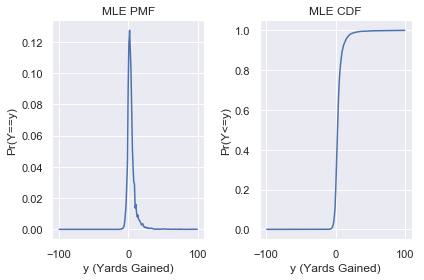

In [6]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='MLE PMF')
axes[1].plot(np.arange(-99,100), yard_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF')
plt.tight_layout()

## Squashing probabilities 

In [7]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

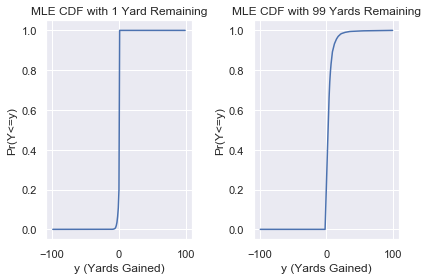

In [8]:
one_cdf = squash(yard_cdf, 1)
ninenine_cdf = squash(yard_cdf, 99)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), one_cdf)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 1 Yard Remaining')
axes[1].plot(np.arange(-99,100), ninenine_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 99 Yards Remaining')
plt.tight_layout()

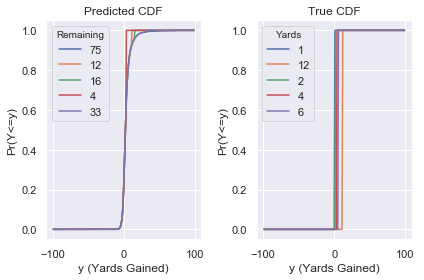

In [9]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    row = row.to_frame().T # convert series to dataframe where indices are columns
    row, tables = preprocess(row, init_tables=tables) # apply processing to rows
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'][0])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards'][0]:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'][0])

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

## Loss for model using all of the data

In [10]:
dev_processed, tables = preprocess(dev, init_tables=tables) # apply to whole df at once here
all_loss = []
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014036657158360893


## Investigating loss/cost

(Cost, Yards Remaining)


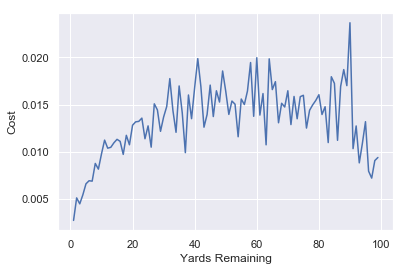

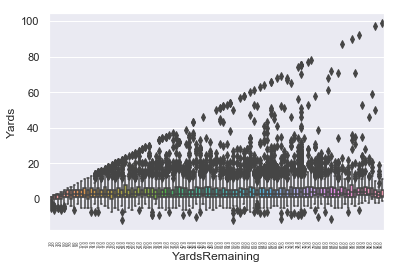

In [11]:
# dict to store [cumulative loss, # loss terms] for each yard_remaining
all_loss = {yard_remaining:[0, 0] for yard_remaining in range(1, 100)}
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['YardsRemaining'])][0] += loss
    all_loss[int(row['YardsRemaining'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Yards Remaining)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

# Make plot, easier to interpret
sorted_yard_cost = sorted(((k,v) for k,v in cost.items()))
sorted_cost = []
for yards_remaining, avg_loss in sorted_yard_cost:
    sorted_cost.append(avg_loss)
plt.plot(np.arange(1,100), sorted_cost)
plt.xlabel('Yards Remaining')
plt.ylabel('Cost')
plt.figure()

ax = sns.boxplot(x="YardsRemaining", y="Yards", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=4);

In [12]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in range(3, 12)}
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['DefendersInTheBox'])][0] += loss
    all_loss[int(row['DefendersInTheBox'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Defenders In The Box)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Defenders In The Box)


[(0.021185343894317057, 3),
 (0.019247867277244493, 4),
 (0.016352949463524565, 9),
 (0.01564676018802821, 5),
 (0.014543252942358524, 7),
 (0.014517084496010479, 6),
 (0.012457648596647499, 8),
 (0.0038478833385227978, 10),
 (0.003504392930578501, 11)]

In [13]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in train.Position.unique()}
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[row['Position']][0] += loss
    all_loss[row['Position']][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Position)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Position)


[(0.023405167785530263, 'WR'),
 (0.022199192829856995, 'TE'),
 (0.015981095704072586, 'HB'),
 (0.014167351586112436, 'Other'),
 (0.013720091397564289, 'RB'),
 (0.01199359448080937, 'QB'),
 (0.010139527919485214, 'FB')]

## A new take on squashing

In [49]:
# squash probabilities
def squash_pmf(yard_probabilities, squash_yard_lower, squash_yard_upper):
    squash_pmf = yard_probabilities.copy()
    lower_prob = np.sum(squash_pmf[0:99+squash_yard_lower])
    upper_prob = np.sum(squash_pmf[99+squash_yard_upper:])
    total_prob = upper_prob + lower_prob
    squash_pmf = squash_pmf / (1-total_prob)
    squash_pmf[0:99+squash_yard_lower] = 0
    squash_pmf[99+squash_yard_upper:] = 0
    return squash_pmf

In [52]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

max:  87
min:  -4
max:  68
min:  -7
max:  92
min:  -5
max:  31
min:  -4
max:  30
min:  -4


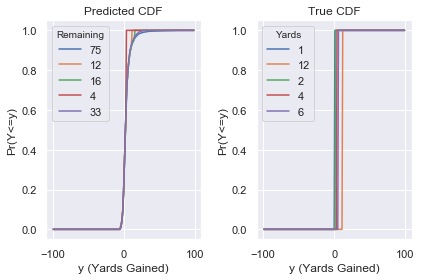

In [53]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    row = row.to_frame().T # convert series to dataframe where indices are columns
    row, tables = preprocess(row, init_tables=tables) # apply processing to rows
    if int(row['Carries']) > 10:
        squashed_pmf = squash_pmf(yard_probabilities, int(row['RusherMinYards']), int(row['RusherMaxYards']))
        print("max: ", int(row['RusherMaxYards']))
        print("min: ", int(row['RusherMinYards']))
    else:
        squashed_pmf = yard_probabilities
    pred_cdf = np.cumsum(squashed_pmf)
    pred_cdf = squash(pred_cdf, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'][0])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards'][0]:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'][0])

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

In [55]:
all_loss = []
for index, row in dev_processed.iterrows():
    if int(row['Carries']) > 10:
        squashed_pmf = squash_pmf(yard_probabilities, int(row['RusherMinYards']), int(row['RusherMaxYards']))
    else:
        squashed_pmf = yard_probabilities
    pred_cdf = np.cumsum(squashed_pmf)
    pred_cdf = squash(pred_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014050291421592085


## Laplace Smoothing

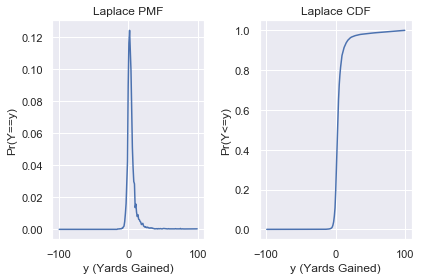

In [22]:
# calculate laplace pmf
total_count = sum(yard_counts)
lower = -15
upper = 100
n_smoothed = upper - lower
for yard in range(lower, upper):
    yard_counts[99+yard] += 1
yard_probabilities_laplace = yard_counts/(total_count+n_smoothed)

# calculate laplce cdf
yard_cdf_laplace = np.cumsum(yard_probabilities_laplace)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities_laplace)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='Laplace PMF')
axes[1].plot(np.arange(-99,100), yard_cdf_laplace)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Laplace CDF')
plt.tight_layout()

max:  87
min:  -4
max:  68
min:  -7
max:  92
min:  -5
max:  31
min:  -4
max:  30
min:  -4


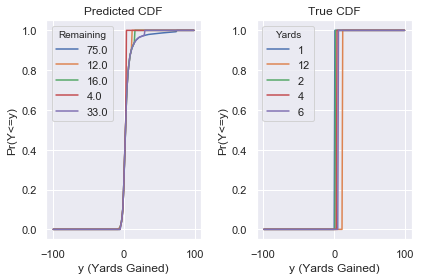

In [28]:
fig, axes = plt.subplots(1, 2)

for index, row in dev_processed.head().iterrows():
    if int(row['Carries']) > 10:
        pred_cdf = squash_upper(yard_cdf_laplace, int(row['RusherMaxYards']))
        pred_cdf = squash_lower(pred_cdf, int(row['RusherMinYards']))
        print("max: ", int(row['RusherMaxYards']))
        print("min: ", int(row['RusherMinYards']))
    else:
        pred_cdf = yard_cdf_laplace
    pred_cdf = squash(pred_cdf, int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

In [30]:
all_loss = []
for index, row in dev_processed.iterrows():
    if int(row['Carries']) > 10:
        pred_cdf = squash_upper(yard_cdf_laplace, int(row['RusherMaxYards']))
        pred_cdf = squash_lower(pred_cdf, int(row['RusherMinYards']))
    else:
        pred_cdf = yard_cdf_laplace
    pred_cdf = squash(pred_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.01405726273083417


(Cost, Yards Remaining)


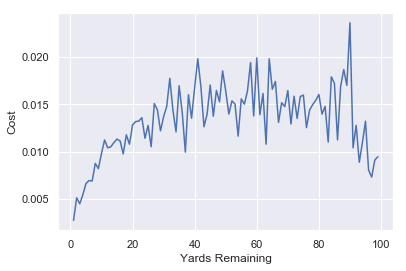

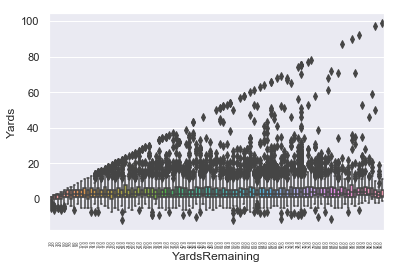

In [22]:
# dict to store [cumulative loss, # loss terms] for each yard_remaining
all_loss = {yard_remaining:[0, 0] for yard_remaining in range(1, 100)}
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf_laplace, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['YardsRemaining'])][0] += loss
    all_loss[int(row['YardsRemaining'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Yards Remaining)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

# Make plot, easier to interpret
sorted_yard_cost = sorted(((k,v) for k,v in cost.items()))
sorted_cost = []
for yards_remaining, avg_loss in sorted_yard_cost:
    sorted_cost.append(avg_loss)
plt.plot(np.arange(1,100), sorted_cost)
plt.xlabel('Yards Remaining')
plt.ylabel('Cost')
plt.figure()

ax = sns.boxplot(x="YardsRemaining", y="Yards", data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=4);

# Perform MLE Segmented by Yardline

## Find model for each yard line

In [23]:
yard_counts = np.zeros((99,199), dtype = 'uint32')
yard_probabilities = np.zeros((99,199), dtype = 'float')

for yard_remaining in range(1,100):
    yards_current = train.Yards[train['YardsRemaining']==yard_remaining]
    
    for yard in range(-99, 100):
        yard_counts[yard_remaining-1,yard+99] = sum(yards_current==yard)
        
    yard_probabilities[yard_remaining-1,:] = yard_counts[yard_remaining-1,:] / np.sum(yard_counts[yard_remaining-1,:])
    
# CDF 
yard_cdf = np.zeros(yard_probabilities.shape)
for yard_remaining in range(1, 100):
    yard_cdf[yard_remaining-1] = np.cumsum(yard_probabilities[yard_remaining-1,:])

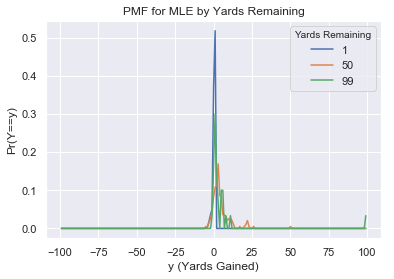

In [24]:
for yard_line in [1,50,99]:
    yard_line_index = yard_line -1
    plt.plot(np.arange(-99,100),yard_probabilities[yard_line_index,:], label = str(yard_line))
    
plt.title('PMF for MLE by Yards Remaining')
plt.ylabel('Pr(Y==y)')
plt.xlabel('y (Yards Gained)')
plt.legend(title='Yards Remaining');

In [25]:
all_loss = []
for index, row in dev_processed.iterrows():
    pred_cdf = squash(yard_cdf[int(row['YardsRemaining'])-1,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014083029592191241


# Boosted MLE by Yardline

## Using Gaussian kernel method to boost models for each yard line

In [26]:
#tune this as needed
sigma = 16
boosted_cdf = np.zeros(199)
weights = []
for true_remaining in range(1,100):
    for model_remaining in range (1,100):
        yard_line_cdf = yard_cdf[model_remaining-1,:]
        weight = np.exp(-((true_remaining - model_remaining)**2) / (2*(sigma**2)))
        weights.append(weight)
        boosted_cdf += weight*yard_line_cdf
        
#normalize the cdf
boosted_cdf /= np.sum(weights)  

## Compute loss for weighted model

In [27]:
all_loss = []
for index, row in dev_processed.iterrows():
    pred_cdf = squash(boosted_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.01403782626016346
